In [171]:
import sys

sys.path.append("../python")
sys.path.append("../pytorch-cnn-visualizations/src")

from facenet_pytorch import MTCNN, InceptionResnetV1
from hsemotion.facial_emotions import HSEmotionRecognizer
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as transforms

from preprocess_data import EigenfacesDataset

In [2]:
# if torch.cuda.is_available():
#     device_name = "cuda"
# elif torch.backends.mps.is_available():
#     device_name = "mps"
# else:
device_name = "cpu"
device = torch.device(device_name)

In [3]:
torch.manual_seed(315)
plt.rcParams['font.size'] = '16'

In [112]:
NUM_EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
SCALE=1

In [113]:
def train(net, train_loader, test_loader,
          num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
          compute_accs=False):
    """
    This function trains the given network on the training data for the given number of epochs.
    If compute_accs is true, evaluates the train and test accuracy of the network at the end of
    each epoch.

    Args:
        net: The neural network to train
        train_loader, test_loader: The pytorch dataset loaders for the trainst and testset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and test
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and test accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer
    # (algorithm like gradient descent). Here we use a common loss function for multi-class
    # classification called the Cross Entropy Loss and the popular Adam algorithm.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for images, labels in train_loader:   # Loop over each batch in train_loader
            # If you are using a GPU, speed up computation by moving values to the GPU
            net = net.to(device)
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true 
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes
            
            if batch_num % BATCH_SIZE == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

            batch_num += 1

        if compute_accs:
            train_acc = accuracy(net, train_loader)
            test_acc = accuracy(net, test_loader)

            print(f'Epoch [{epoch}/{num_epochs}], ',
                  f'Train Accuracy {100 * train_acc:.2f}%, ',
                  f'Test Accuracy {100 * test_acc:.2f}%')
            
            train_accs.append(train_acc)
            test_accs.append(test_acc)

    if compute_accs:
        return train_accs, test_accs
    else:
        return None


def accuracy(net, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count

    return correct / total


def plot_history(histories):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained.
                   Each dictionary should have the keys:
                        * train_accs: A list of train accuracies
                        * test_accs: A list of test accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      label = model_history['label']
      val = plt.plot(epochs, model_history['test_accs'],
                     '--', label=label + ' test')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
               label=label + ' train')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])

In [237]:
class OneConvolutionNet(nn.Module):
    def __init__(self, num_classes, pretrained):
        super(OneConvolutionNet, self).__init__()
        self.pretrained = pretrained
        self.features = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=25,
                kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2),
            nn.Flatten(1, -1))
        self.classifier = nn.Sequential(
            nn.LazyLinear(out_features=num_classes))

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class TwoConvolutionNet(nn.Module):
    def __init__(self, num_classes, pretrained):
        super(TwoConvolutionNet, self).__init__()
        self.pretrained = pretrained
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=20,
            kernel_size=5)
        self.conv2 = nn.Conv2d(
            in_channels=20,
            out_channels=50,
            kernel_size=5)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2)
        self.linear1 = nn.LazyLinear(out_features=25)
        self.linear2 = nn.LazyLinear(out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

class VggNet(nn.Module):
    def __init__(self, num_classes, pretrained):
        super(VggNet, self).__init__()
        self.pretrained = pretrained
        if self.pretrained:
            self.model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
            for param in self.model.parameters():
                param.requires_grad = False
        else:
            self.model = models.vgg11()
        self.model.classifier = nn.Sequential(
            nn.LazyLinear(255), nn.ReLU(),
            nn.LazyLinear(num_classes))

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = self.model.forward(x)
        return x

class UntrainedInceptionResnet(nn.Module):
    def __init__(self, num_classes, image_size):
        super(UntrainedInceptionResnet, self).__init__()
        self.resnet = InceptionResnetV1(
            classify=True, num_classes=num_classes, device=device).eval()

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = self.resnet.forward(x)
        return x

class PretrainedInceptionResnet(nn.Module):
    def __init__(self, num_classes, image_size):
        super(PretrainedInceptionResnet, self).__init__()
        self.resnet = InceptionResnetV1(
            pretrained='vggface2', classify=True, device=device).eval()
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.linear1 = nn.LazyLinear(out_features=25)
        self.linear2 = nn.LazyLinear(out_features=num_classes)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = self.resnet.forward(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x    
    
class PretrainedInceptionResnet(nn.Module):
    def __init__(self, num_classes, image_size):
        super(PretrainedInceptionResnet, self).__init__()
        self.resnet = InceptionResnetV1(
            pretrained='vggface2', classify=True, device=device).eval()
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.linear1 = nn.LazyLinear(out_features=25)
        self.linear2 = nn.LazyLinear(out_features=num_classes)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = self.resnet.forward(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

class FerNet(nn.Module):
    def __init__(self, num_classes):
        super(FerNet, self).__init__()
        model_name = 'enet_b2_8'
        self.fer = HSEmotionRecognizer(model_name=model_name, device=device)
        self.linear1 = nn.LazyLinear(out_features=25)
        self.linear2 = nn.LazyLinear(out_features=num_classes)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = self.fer.model(x)
        x = self.fer.get_probab(x)
        self.linear1 = nn.LazyLinear(out_features=25)
        self.linear2 = nn.LazyLinear(out_features=num_classes)
        return x

In [279]:
def get_loader(label, data_dir):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(0.5, 0.5)])
    dataset = EigenfacesDataset(
        data_dir=data_dir,
        label=label,
        scale=SCALE,
        transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
    return dataloader

def make_net(label, net_name, pretrained):
    train_loader = get_loader(label, '../train_data')
    test_loader = get_loader(label, '../test_data')
    num_classes = train_loader.dataset.num_classes
    if net_name == 'OneConvolutionNet':
        net = OneConvolutionNet(num_classes, pretrained)
    elif net_name == 'TwoConvolutionNet':
        net = TwoConvolutionNet(num_classes, pretrained)
    elif net_name == 'VggNet':
        net = VggNet(num_classes, pretrained)
    elif net_name == 'PretrainedInceptionResnet':
        net = PretrainedInceptionResnet(num_classes, train_loader.dataset.height)
    elif net_name == 'UntrainedInceptionResnet':
        net = UntrainedInceptionResnet(num_classes, train_loader.dataset.height)
    elif net_name == 'FerNet':
        net = FerNet(num_classes)
    return (net, train_loader, test_loader)

def run_models(net_name, pretrained=False):
    labels = ['eye_state', 'facial_expression', 'head_position']
    nets = {}
    histories = []
    for label in labels:
        net, train_loader, test_loader = make_net(label, net_name, pretrained)
        train_history, test_history = train(
            net, train_loader, test_loader, 
            num_epochs=NUM_EPOCHS, 
            learning_rate=LEARNING_RATE, 
            compute_accs=True)
        histories.append({
            'label': label,
            'train_accs': train_history,
            'test_accs': test_history
        })
        nets[label] = net

    plot_history(histories)
    return (nets, histories)

In [280]:
# fer_nets = run_models('FerNet')

In [281]:
# pretrained_inception_resnets = run_models('PretrainedInceptionResnet')

In [282]:
# untrained_inception_resnets = run_models('UntrainedInceptionResnet')

/Users/apple/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/20],  Train Accuracy 85.48%,  Test Accuracy 88.58%
Epoch [2/20],  Train Accuracy 90.32%,  Test Accuracy 82.19%
Epoch [3/20],  Train Accuracy 92.47%,  Test Accuracy 86.76%
Epoch [4/20],  Train Accuracy 99.46%,  Test Accuracy 91.32%
Epoch [5/20],  Train Accuracy 95.70%,  Test Accuracy 88.58%
Epoch [6/20],  Train Accuracy 99.46%,  Test Accuracy 90.41%
Epoch [7/20],  Train Accuracy 98.92%,  Test Accuracy 92.24%
Epoch [8/20],  Train Accuracy 98.92%,  Test Accuracy 92.24%
Epoch [9/20],  Train Accuracy 100.00%,  Test Accuracy 92.69%
Epoch [10/20],  Train Accuracy 100.00%,  Test Accuracy 90.41%
Epoch [11/20],  Train Accuracy 100.00%,  Test Accuracy 90.87%
Epoch [12/20],  Train Accuracy 100.00%,  Test Accuracy 90.41%
Epoch [13/20],  Train Accuracy 100.00%,  Test Accuracy 90.41%
Epoch [14/20],  Train Accuracy 100.00%,  Test Accuracy 90.87%
Epoch [15/20],  Train Accuracy 100.00%,  Test Accuracy 90.87%
Epoch [16/20],  Train Accuracy 100.00%,  Test Accuracy 90.87%
Epoch [17/20],  Train Acc

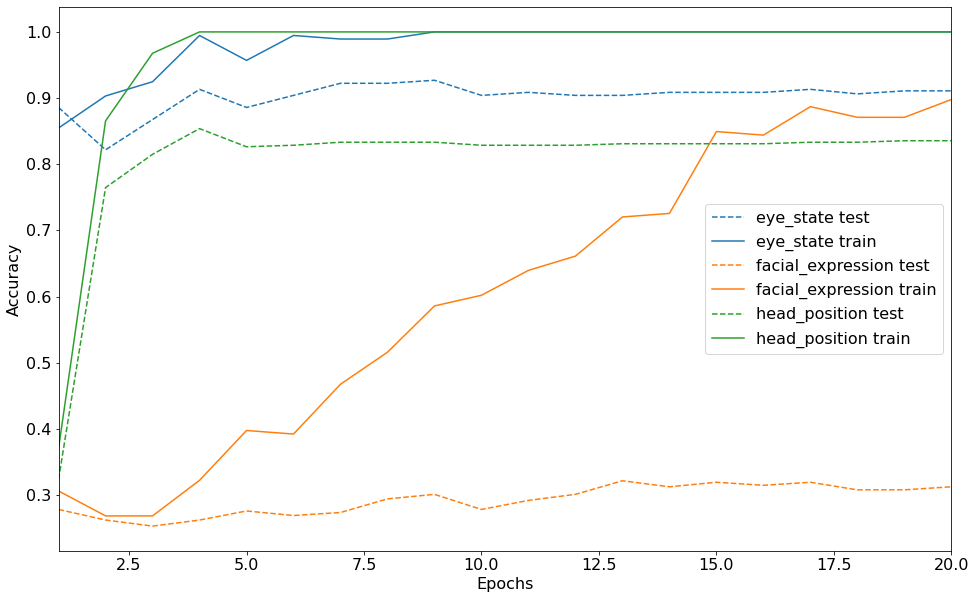

In [283]:
(vgg_nets, vgg_nets_history) = run_models('VggNet', pretrained=True)

Epoch [1/20],  Train Accuracy 50.00%,  Test Accuracy 50.23%
Epoch [2/20],  Train Accuracy 50.00%,  Test Accuracy 49.77%
Epoch [3/20],  Train Accuracy 52.69%,  Test Accuracy 52.51%
Epoch [4/20],  Train Accuracy 50.00%,  Test Accuracy 49.77%
Epoch [5/20],  Train Accuracy 50.00%,  Test Accuracy 49.77%
Epoch [6/20],  Train Accuracy 83.87%,  Test Accuracy 84.02%
Epoch [7/20],  Train Accuracy 50.00%,  Test Accuracy 50.23%
Epoch [8/20],  Train Accuracy 50.00%,  Test Accuracy 50.23%
Epoch [9/20],  Train Accuracy 50.00%,  Test Accuracy 50.23%
Epoch [10/20],  Train Accuracy 50.00%,  Test Accuracy 50.23%
Epoch [11/20],  Train Accuracy 50.00%,  Test Accuracy 50.23%
Epoch [12/20],  Train Accuracy 50.00%,  Test Accuracy 50.23%
Epoch [13/20],  Train Accuracy 50.00%,  Test Accuracy 50.23%
Epoch [14/20],  Train Accuracy 50.00%,  Test Accuracy 50.91%
Epoch [15/20],  Train Accuracy 50.00%,  Test Accuracy 50.23%
Epoch [16/20],  Train Accuracy 63.44%,  Test Accuracy 67.35%
Epoch [17/20],  Train Accuracy 82

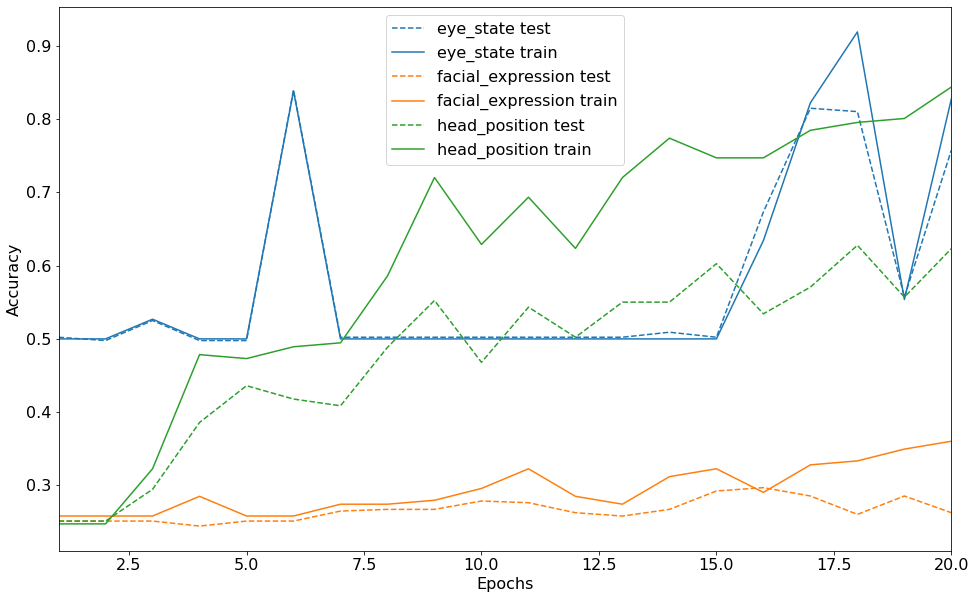

In [289]:
(vgg_nets_untrained, vgg_nets_untrained_history) = run_models('VggNet', pretrained=False)

Epoch [1/20],  Train Accuracy 50.00%,  Test Accuracy 50.23%
Epoch [2/20],  Train Accuracy 54.84%,  Test Accuracy 50.23%
Epoch [3/20],  Train Accuracy 50.00%,  Test Accuracy 49.77%
Epoch [4/20],  Train Accuracy 65.59%,  Test Accuracy 60.27%
Epoch [5/20],  Train Accuracy 60.22%,  Test Accuracy 50.46%
Epoch [6/20],  Train Accuracy 79.03%,  Test Accuracy 62.33%
Epoch [7/20],  Train Accuracy 63.98%,  Test Accuracy 52.28%
Epoch [8/20],  Train Accuracy 82.26%,  Test Accuracy 61.64%
Epoch [9/20],  Train Accuracy 80.65%,  Test Accuracy 55.94%
Epoch [10/20],  Train Accuracy 83.87%,  Test Accuracy 56.85%
Epoch [11/20],  Train Accuracy 94.62%,  Test Accuracy 61.42%
Epoch [12/20],  Train Accuracy 89.78%,  Test Accuracy 62.10%
Epoch [13/20],  Train Accuracy 93.55%,  Test Accuracy 63.24%
Epoch [14/20],  Train Accuracy 96.24%,  Test Accuracy 62.10%
Epoch [15/20],  Train Accuracy 93.55%,  Test Accuracy 62.33%
Epoch [16/20],  Train Accuracy 94.62%,  Test Accuracy 62.79%
Epoch [17/20],  Train Accuracy 98

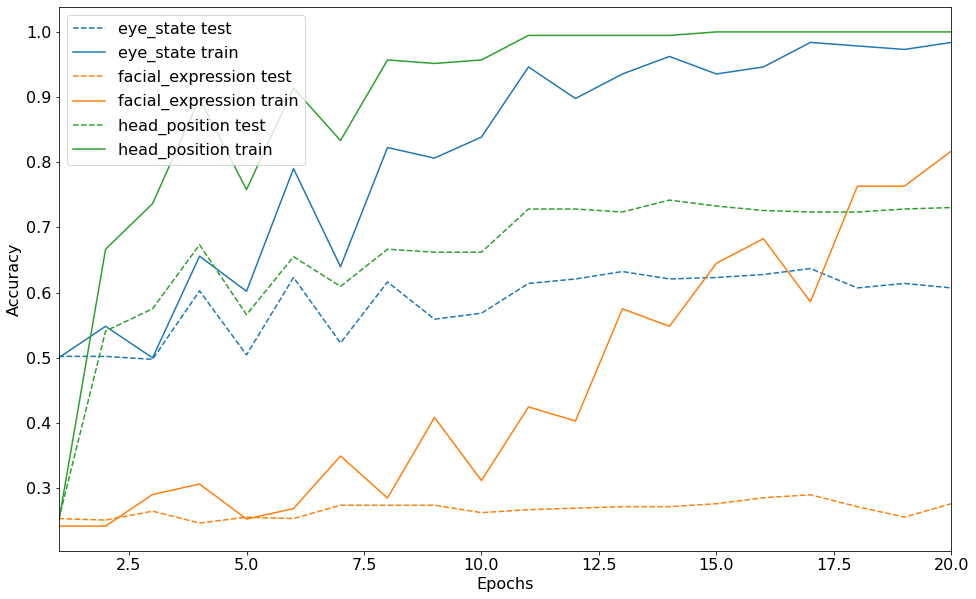

In [285]:
(one_conv_nets, one_conv_nets_history) = run_models('OneConvolutionNet', pretrained=False)

Epoch [1/20],  Train Accuracy 50.00%,  Test Accuracy 49.77%
Epoch [2/20],  Train Accuracy 76.34%,  Test Accuracy 55.71%
Epoch [3/20],  Train Accuracy 88.17%,  Test Accuracy 64.84%
Epoch [4/20],  Train Accuracy 86.56%,  Test Accuracy 64.61%
Epoch [5/20],  Train Accuracy 85.48%,  Test Accuracy 68.26%
Epoch [6/20],  Train Accuracy 89.78%,  Test Accuracy 65.75%
Epoch [7/20],  Train Accuracy 91.40%,  Test Accuracy 64.38%
Epoch [8/20],  Train Accuracy 94.62%,  Test Accuracy 65.75%
Epoch [9/20],  Train Accuracy 88.71%,  Test Accuracy 70.55%
Epoch [10/20],  Train Accuracy 93.01%,  Test Accuracy 65.07%
Epoch [11/20],  Train Accuracy 95.70%,  Test Accuracy 63.93%
Epoch [12/20],  Train Accuracy 94.62%,  Test Accuracy 69.63%
Epoch [13/20],  Train Accuracy 97.31%,  Test Accuracy 65.07%
Epoch [14/20],  Train Accuracy 99.46%,  Test Accuracy 65.07%
Epoch [15/20],  Train Accuracy 96.24%,  Test Accuracy 67.12%
Epoch [16/20],  Train Accuracy 99.46%,  Test Accuracy 66.21%
Epoch [17/20],  Train Accuracy 10

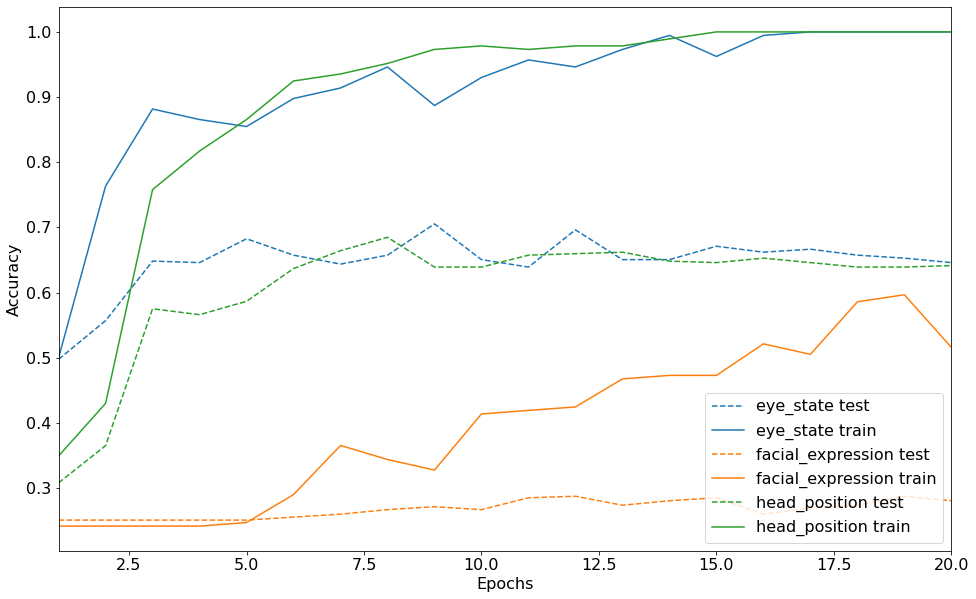

In [286]:
(two_conv_nets, two_conv_nets_history) = run_models('TwoConvolutionNet', pretrained=False)

In [ ]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.detach().cpu().numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].detach().cpu().numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg, cmap='gray')
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [ ]:
# plot_filters_single_channel(one_conv_nets['eye_state'].conv.weight)

In [ ]:
# plot_filters_single_channel(one_conv_nets['facial_expression'].conv.weight)

In [ ]:
# plot_filters_single_channel(one_conv_nets['head_position'].conv.weight)

In [ ]:
# plot_filters_single_channel(two_conv_nets['head_position'].conv1.weight)

In [ ]:
# plot_filters_single_channel(two_conv_nets['head_position'].conv2.weight)

In [126]:
def plot_feature_maps(label, nets, img_num):
    test_loader = get_loader(label, '../test_data')
    X = test_loader.dataset[img_num][0]
    X = X.to(device)
    
    model = nets[label].eval()
    model.eval()
    with torch.no_grad():
        if nets.__class__.__name__ == 'OneConvolutionNet':
            feature_maps = model.pool(F.relu(model.conv(X)))
        else:
            feature_maps = self.features(x) 

#     elif num_conv == 2:
#         model = nets[label]
#         model.eval()
#         with torch.no_grad():
#             feature_maps = model.pool(F.relu(model.conv1(X)))
#             if conv_layer == 2:
#                 feature_maps = model.pool(F.relu(model.conv2(feature_maps)))
#     else:
#         raise Exception("Number of convolutions must be 1 or 2")

    num_plots = feature_maps.size()[0]
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots/num_rows))
    fig, ax = plt.subplots(num_rows, num_cols, sharex=True, sharey=True, figsize=(15, 15))
    for i in range(0, num_plots):
        row, col = i//num_cols, i%num_cols
        ax[row][col].imshow(feature_maps[i].cpu(), cmap='gray')
        ax[row][col].axis("off")
    # plt.show()
    plt.savefig("../results/cnn_{}_img_{}_label_{}".format(
        nets.__class__.__name__, img_num, label))

In [337]:
plot_feature_maps('eye_state', 1, 1, 7)

TypeError: plot_feature_maps() takes 3 positional arguments but 4 were given

In [ ]:
plot_feature_maps('eye_state', 1, 1, 14)

In [ ]:
plot_feature_maps('head_position', 1, 1, 7)

In [ ]:
plot_feature_maps('head_position', 1, 1, 14)

In [ ]:
plot_feature_maps('facial_expression', 1, 1, 7)

In [ ]:
plot_feature_maps('facial_expression', 1, 1, 14)

In [ ]:
# plot_feature_maps('eye_state', 2, 2, 7)

In [ ]:
# plot_feature_maps('eye_state', 2, 2, 14)

In [ ]:
# plot_feature_maps('head_position', 2, 2, 7)

In [ ]:
# plot_feature_maps('head_position', 2, 2, 14)

In [ ]:
# plot_feature_maps('facial_expression', 2, 2, 7)

In [ ]:
# plot_feature_maps('facial_expression', 2, 2, 14)

In [381]:
def confusion_matrix(nets, model_name, label, max_num):
    net = nets[label]
    data_loader = get_loader(label, '../test_data')
    
    y_true = []
    y_pred = []
    
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores

        y_true.extend(labels.detach().cpu().numpy().tolist())
        y_pred.extend(predicted.detach().cpu().numpy().tolist())

    matrix = metrics.confusion_matrix(y_true, y_pred)
    disp = metrics.ConfusionMatrixDisplay(matrix, display_labels=data_loader.dataset.classes)
    matrix_plot = disp.plot(cmap='inferno', colorbar=False)
    matrix_plot.im_.set_clim(vmin=0,vmax=max_num)
    plt.setp(matrix_plot.ax_.get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.setp(matrix_plot.ax_.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    matrix_plot.figure_.savefig(
        "../results/{}_{}_confusion".format(
            model_name, label), bbox_inches='tight')

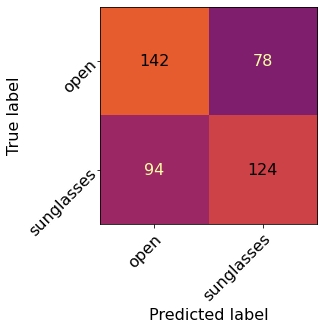

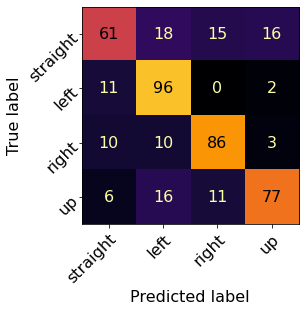

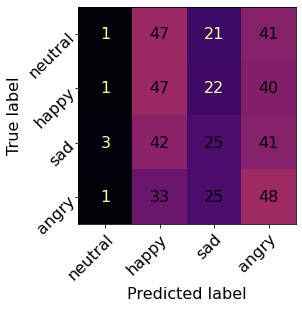

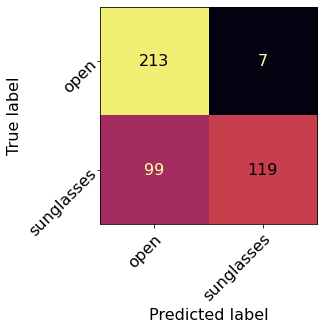

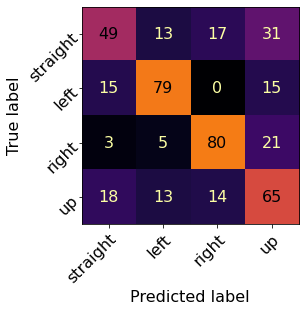

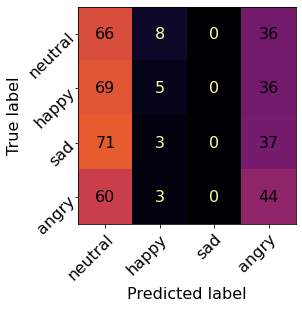

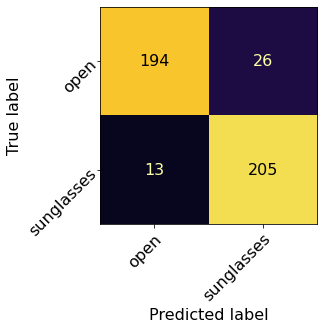

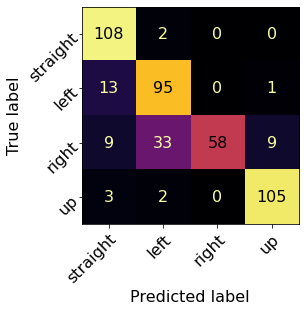

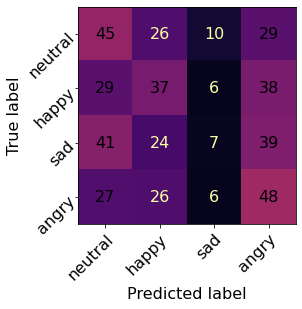

In [382]:
pretty_net = {
    'cnn1': 'One-layer CNN',
    'vgg_untrained': 'Untrained VG11',
    'vgg_trained': 'Pretrained VGG11'}

for nets, model_name in net_names:
    for label, target_classes in label_classes:
        max_num = 14*(32/len(target_classes))
        confusion_matrix(nets, model_name, label, max_num)

In [363]:
from importlib import reload
import generate_regularized_class_specific_samples
reload(generate_regularized_class_specific_samples)
from generate_regularized_class_specific_samples import RegularizedClassSpecificImageGeneration

net_names = [
    (one_conv_nets, 'cnn1'),
    (vgg_nets_untrained, 'vgg_untrained'),
    (vgg_nets, 'vgg_trained')]

label_classes = [
    ('eye_state', [0,1]),
    ('head_position', [0,1,2,3]),
    ('facial_expression', [0,1,2,3])]

for nets, model_name in net_names:
    for label, target_classes in label_classes:
        for target_class in target_classes:
            train_loader = get_loader(label, '../train_data')
            img_size = (train_loader.dataset.width, train_loader.dataset.height)
            csig = RegularizedClassSpecificImageGeneration(
                nets[label], target_class=target_class, num_channels=1,
                img_size=img_size, label=label, model_name=model_name)
            csig.generate()

/Users/apple/Library/CloudStorage/OneDrive-Stanford/eigenfaces/ipynb/../pytorch-cnn-visualizations/src/generate_regularized_class_specific_samples.py:105: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if clipping_value:


Iteration: 16 Loss -15.08
Iteration: 33 Loss -27.41
Iteration: 50 Loss -35.50
Iteration: 66 Loss -37.90
Iteration: 83 Loss -42.38
Iteration: 100 Loss -33.50
Iteration: 116 Loss -33.95
Iteration: 133 Loss -37.80
Iteration: 16 Loss -9.57
Iteration: 33 Loss -17.07
Iteration: 50 Loss -23.30
Iteration: 66 Loss -25.22
Iteration: 83 Loss -29.62
Iteration: 100 Loss -21.50
Iteration: 116 Loss -22.06
Iteration: 133 Loss -25.47
Iteration: 16 Loss -5.98
Iteration: 33 Loss -11.83
Iteration: 50 Loss -16.01
Iteration: 66 Loss -16.96
Iteration: 83 Loss -19.99
Iteration: 100 Loss -12.77
Iteration: 116 Loss -12.94
Iteration: 133 Loss -15.75
Iteration: 16 Loss -19.14
Iteration: 33 Loss -33.76
Iteration: 50 Loss -43.32
Iteration: 66 Loss -45.76
Iteration: 83 Loss -50.99
Iteration: 100 Loss -38.59
Iteration: 116 Loss -38.99
Iteration: 133 Loss -44.05
Iteration: 16 Loss -21.82
Iteration: 33 Loss -35.45
Iteration: 50 Loss -43.65
Iteration: 66 Loss -45.56
Iteration: 83 Loss -50.26
Iteration: 100 Loss -38.71
I

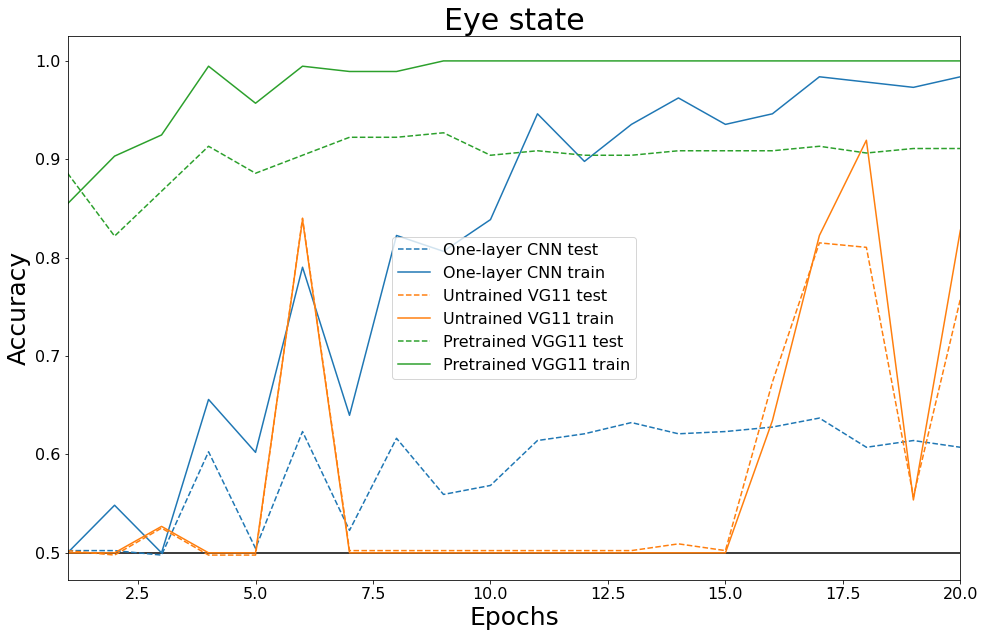

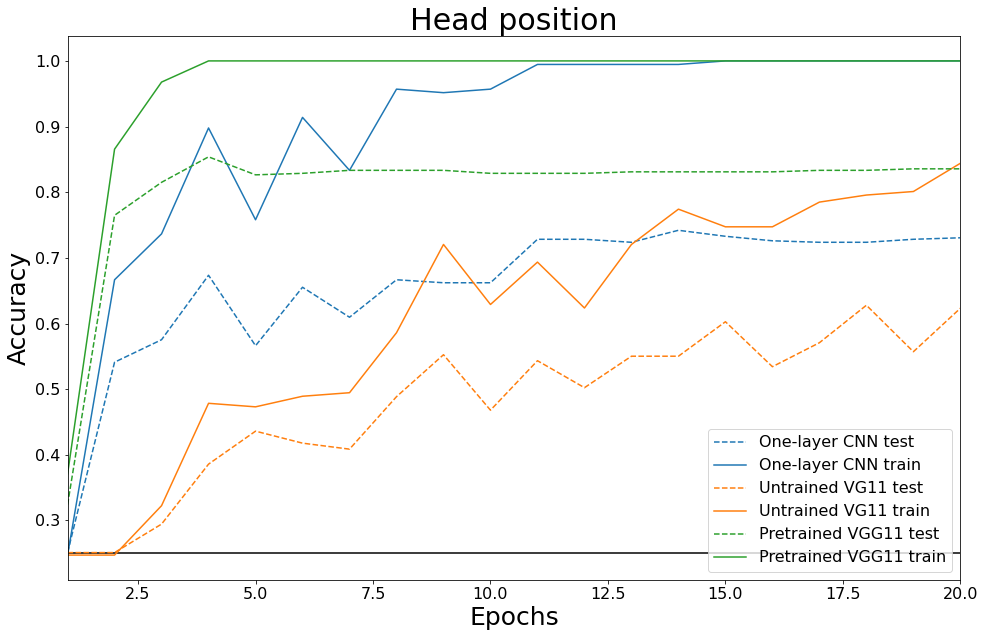

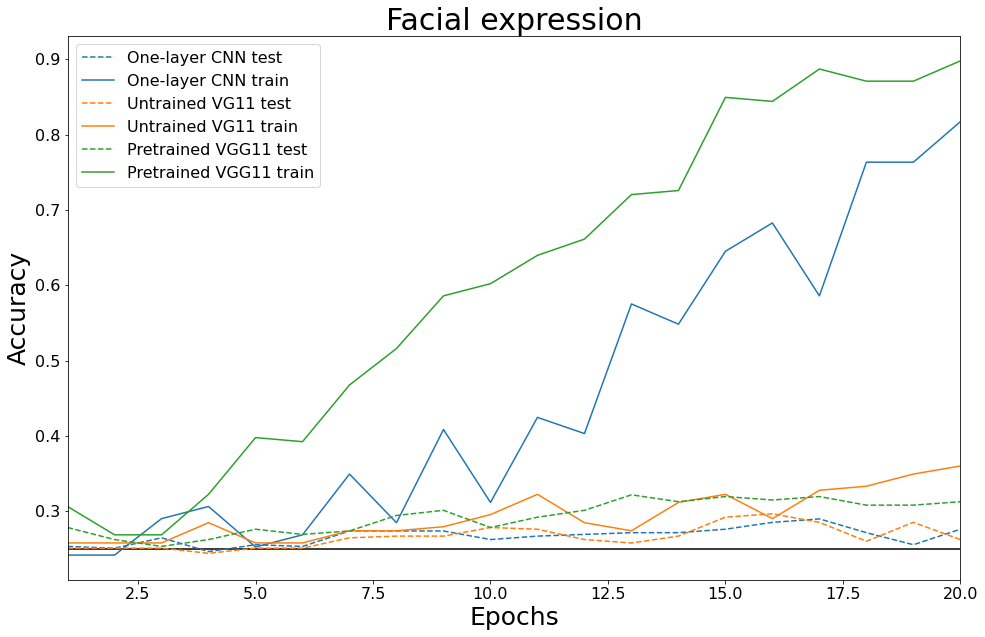

In [373]:
pretty_label = {
    'eye_state': 'Eye state',
    'head_position': 'Head position',
    'facial_expression': 'Facial expression'
}

label_base_accuracy = [
    ('eye_state', 0.5),
    ('head_position', 0.25),
    ('facial_expression', 0.25)]

histories = [
    ('One-layer CNN', one_conv_nets_history),
    ('Untrained VG11', vgg_nets_untrained_history),
    ('Pretrained VGG11', vgg_nets_history)
]

for (label, base_accuracy) in label_base_accuracy:
    plt.figure(figsize=(16,10))
    plt.axhline(base_accuracy, color='black')
    for (name, history) in histories:
        model_history = [h for h in history if h['label'] == label][0]
        epochs = list(range(1, len(model_history['train_accs']) + 1))
        val = plt.plot(epochs, model_history['test_accs'],
                       '--', label=name + ' test')
        plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
                 label=name + ' train')

    plt.xlabel('Epochs', fontsize=25)
    plt.ylabel('Accuracy', fontsize=25)
    plt.legend()
    plt.xlim([1,max(epochs)])
    plt.title(pretty_label.get(label), fontsize=30)